# Liesel-GAM Demo Notebook

## Setup and Imports

In [10]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [11]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

In [12]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366


## Model Definition

### Setup response model

In [13]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)


smooth = tb.ps("area", k=20)

loc += smooth
loc += tb.rs(x=smooth, cluster="district")

loc += tb.ri("district", noncentered=True)

Warning message:
In smooth.construct.ps.smooth.spec(object, dk$data, dk$knots) :
  there is *no* information about some basis coefficients
Warning message:
In smooth.construct.ps.smooth.spec(object, dk$data, dk$knots) :
  there is *no* information about some basis coefficients


### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


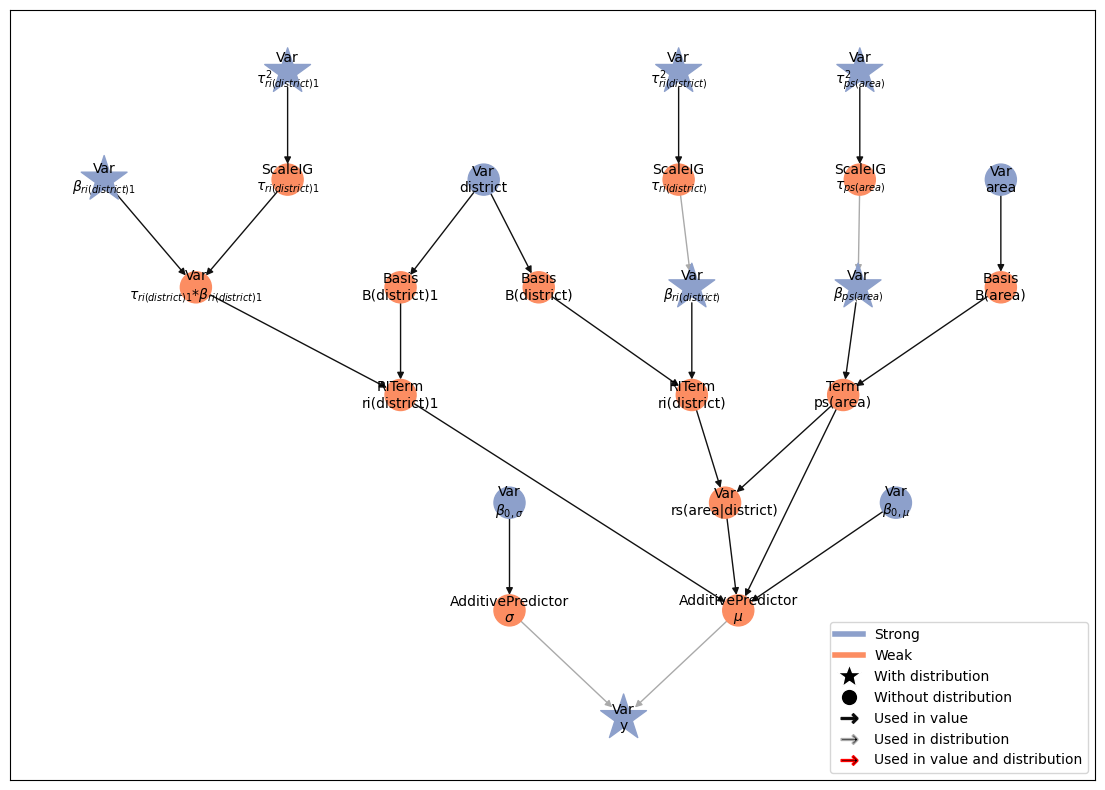

In [14]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [15]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{ri(district)1}$', '$\\tau^2_{ri(district)1}$', '$\\beta_{ri(district)}$', '$\\tau^2_{ri(district)}$', '$\\beta_{ps(area)}$', '$\\tau^2_{ps(area)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.49chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1109.02chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|██████████████████████████████

### MCMC summary

In [16]:
summary = gs.Summary(results)
summary

Parameter summary:

                                   kernel       mean         sd     q_0.05  \
parameter                index                                               
$\beta_{0,\mu}$          ()     kernel_01  35.047554   2.067731  31.591446   
$\beta_{0,\sigma}$       ()     kernel_00   2.622647   0.118833   2.434974   
$\beta_{ps(area)}$       (0,)   kernel_06  -0.006013   0.429391  -0.671547   
                         (1,)   kernel_06  -0.006329   0.446112  -0.709455   
                         (2,)   kernel_06  -0.014455   0.431160  -0.681448   
...                                   ...        ...        ...        ...   
$\beta_{ri(district)}$   (47,)  kernel_04  -0.027255   0.186067  -0.274877   
                         (48,)  kernel_04   0.009124   0.181113  -0.195370   
$\tau^2_{ps(area)}$      ()     kernel_07   0.191003   0.338170   0.005946   
$\tau^2_{ri(district)1}$ ()     kernel_03   2.457290  16.442017   0.001130   
$\tau^2_{ri(district)}$  ()     kernel_05   0.032461   0.096215   0.001657   

                                    q_0.5     q_0.95  sample_size  \
parameter                index                                      
$\beta_{0,\mu}$          ()     35.061100  38.419455         4000   
$\beta_{0,\sigma}$       ()      2.620245   2.817088         4000   
$\beta_{ps(area)}$       (0,)   -0.002831   0.663496         4000   
                         (1,)   -0.001519   0.660717         4000   
                         (2,)   -0.004813   0.622287         4000   
...                                   ...        ...          ...   
$\beta_{ri(district)}$   (47,)  -0.010858   0.173333         4000   
                         (48,)   0.002271   0.222061         4000   
$\tau^2_{ps(area)}$      ()      0.103130   0.640066         4000   
$\tau^2_{ri(district)1}$ ()      0.017759   6.683959         4000   
$\tau^2_{ri(district)}$  ()      0.007221   0.141809         4000   

                                   ess_bulk     ess_tail      rhat  
parameter                index                                      
$\beta_{0,\mu}$          ()     3627.093421  3527.217718  1.000094  
$\beta_{0,\sigma}$       ()     1546.582303  2141.164369  1.001729  
$\beta_{ps(area)}$       (0,)   2973.144284  2489.800545  1.010261  
                         (1,)   3561.531401  2684.742725  1.004560  
                         (2,)   3391.676635  2819.384277  1.009772  
...                                     ...          ...       ...  
$\beta_{ri(district)}$   (47,)  2039.138119   168.738623  1.014406  
                         (48,)  2779.768488   331.561879  1.011944  
$\tau^2_{ps(area)}$      ()      180.242683   303.169980  1.021712  
$\tau^2_{ri(district)1}$ ()      420.741426   481.532050  1.009747  
$\tau^2_{ri(district)}$  ()       87.137669    73.842499  1.029281  

[122 rows x 10 columns]

## Plots

In [17]:
samples = results.get_posterior_samples()

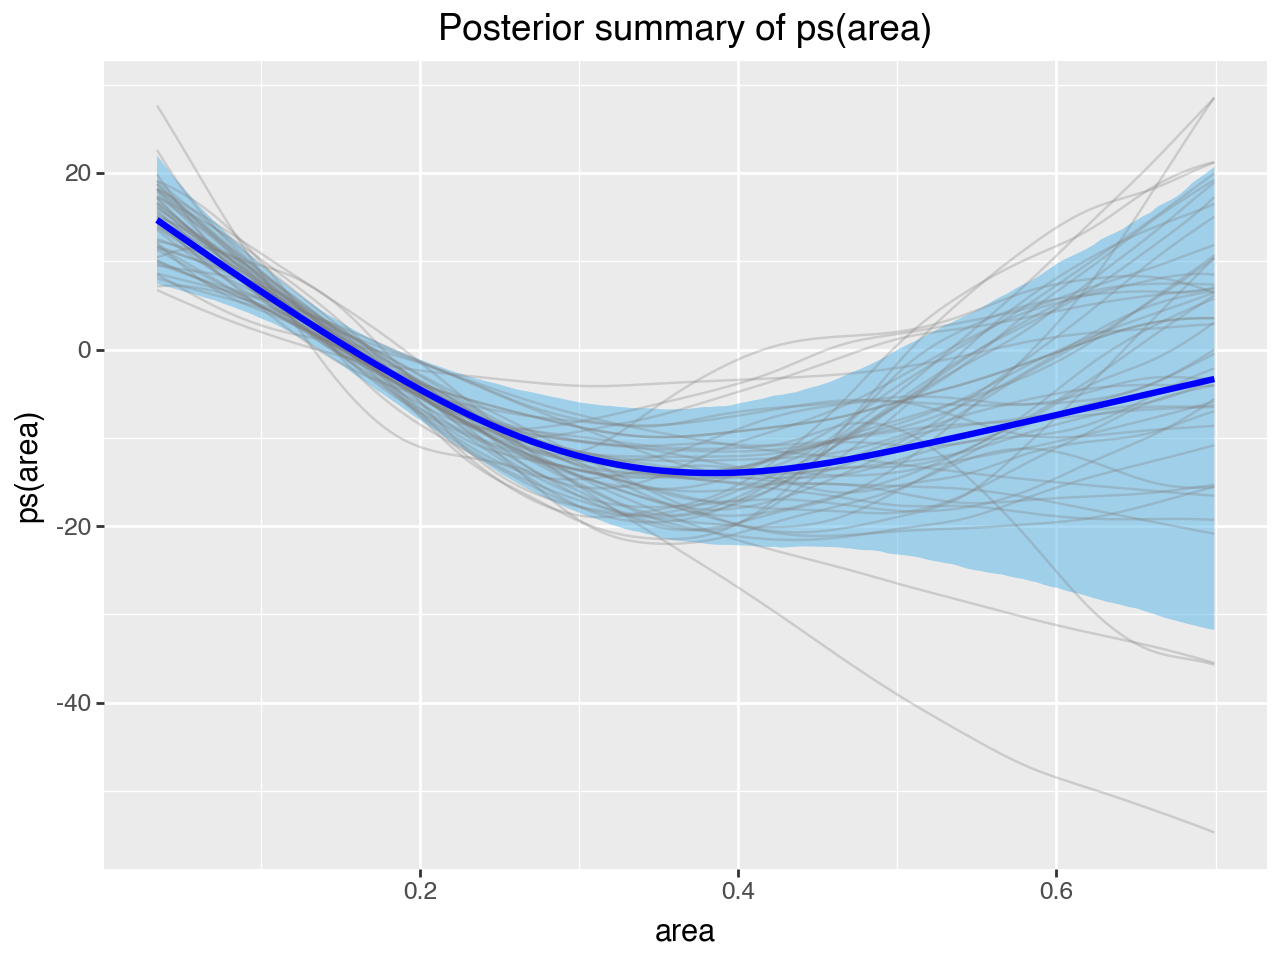

In [18]:
gam.plot_1d_smooth(term=model.vars[smooth.name], samples=samples)

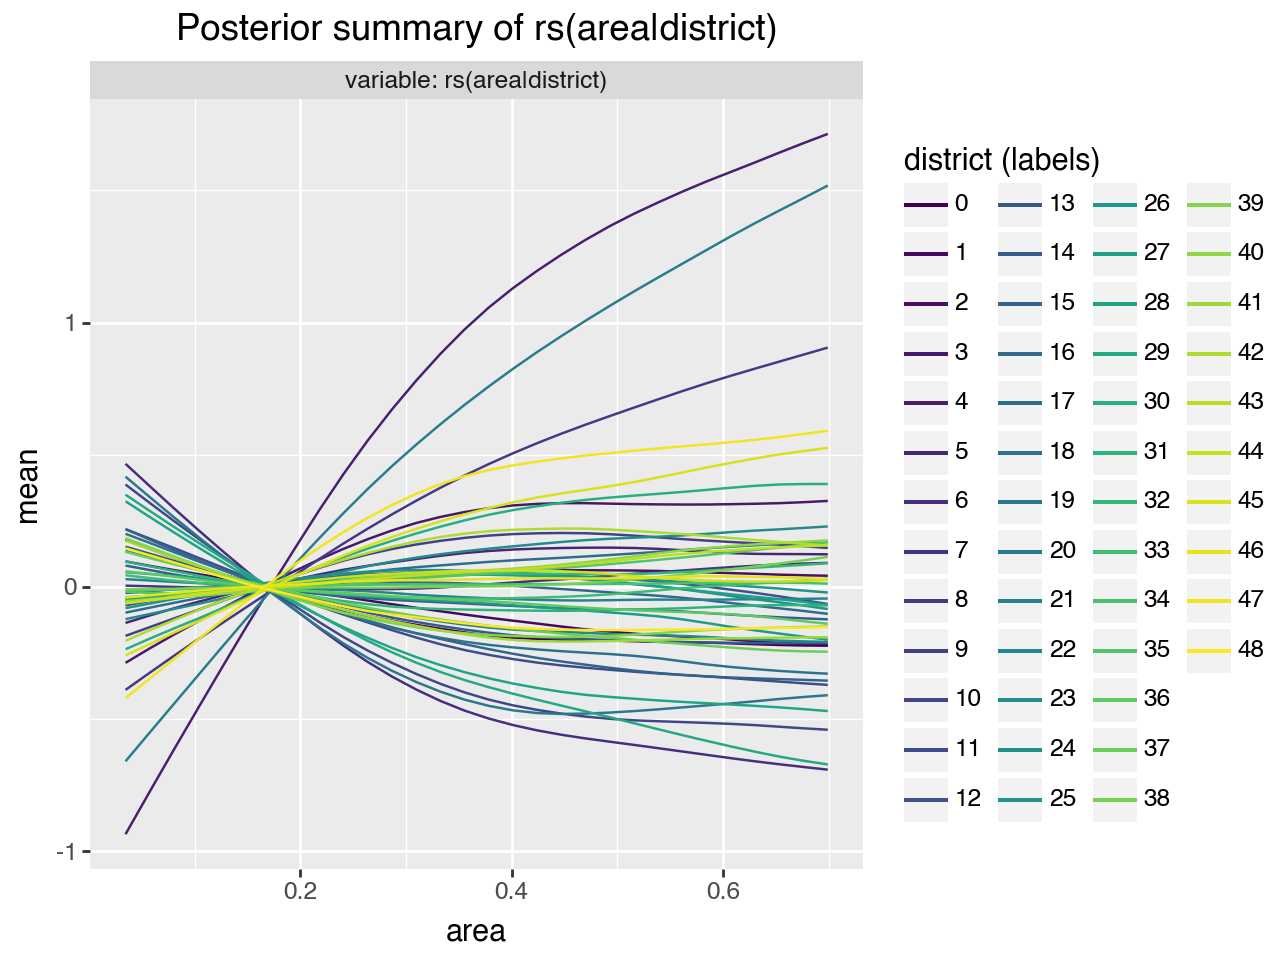

In [19]:
gam.plot_1d_smooth_clustered(
    clustered_term=model.vars["rs(area|district)"],
    samples=samples,
    ngrid=30,
)

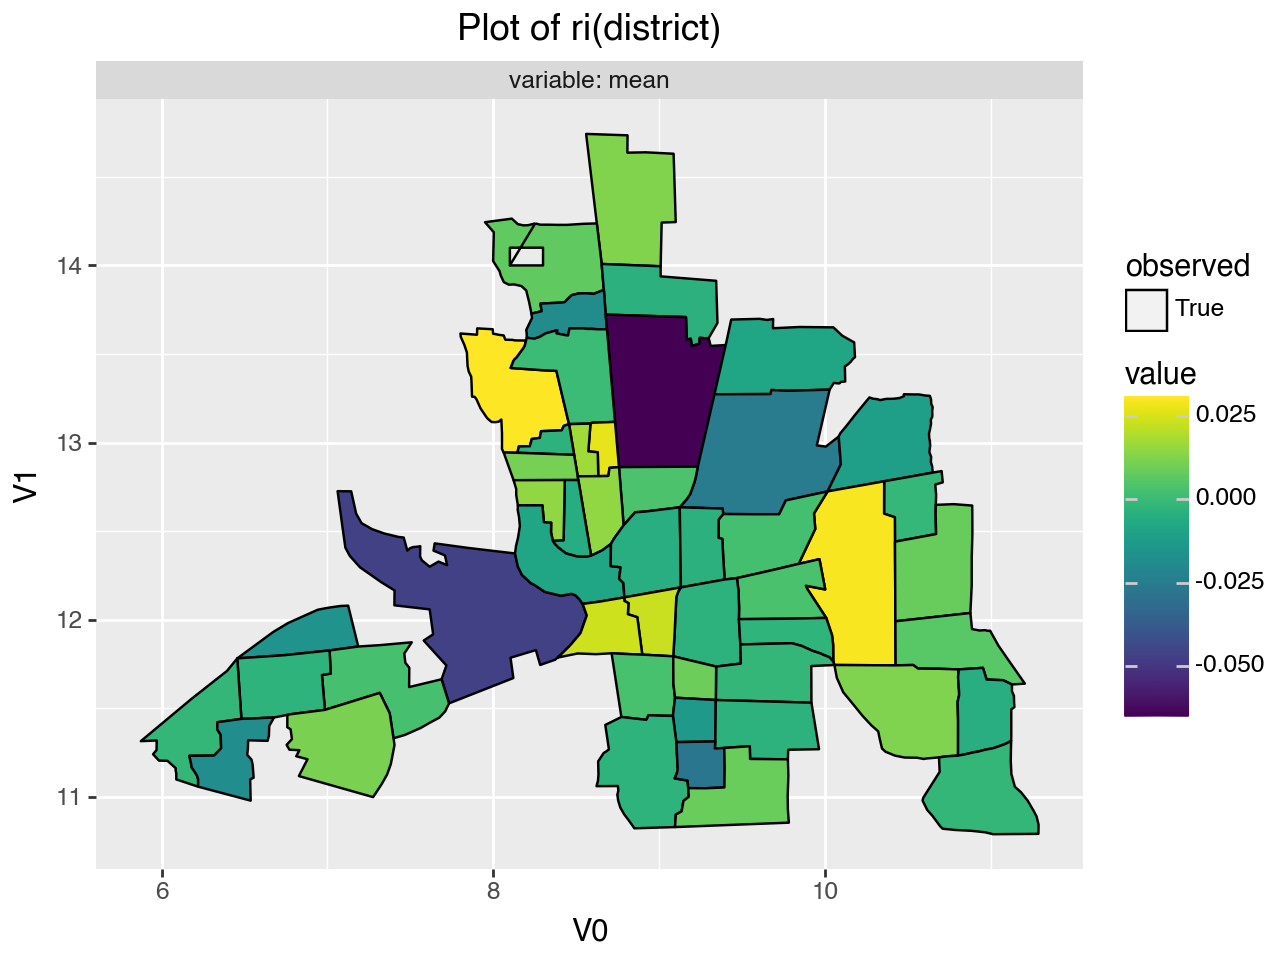

In [20]:
(
    gam.plot_regions(
        term=model.vars["ri(district)"],
        samples=samples,
        polys=polys,
        observed_color="black",
    )
)

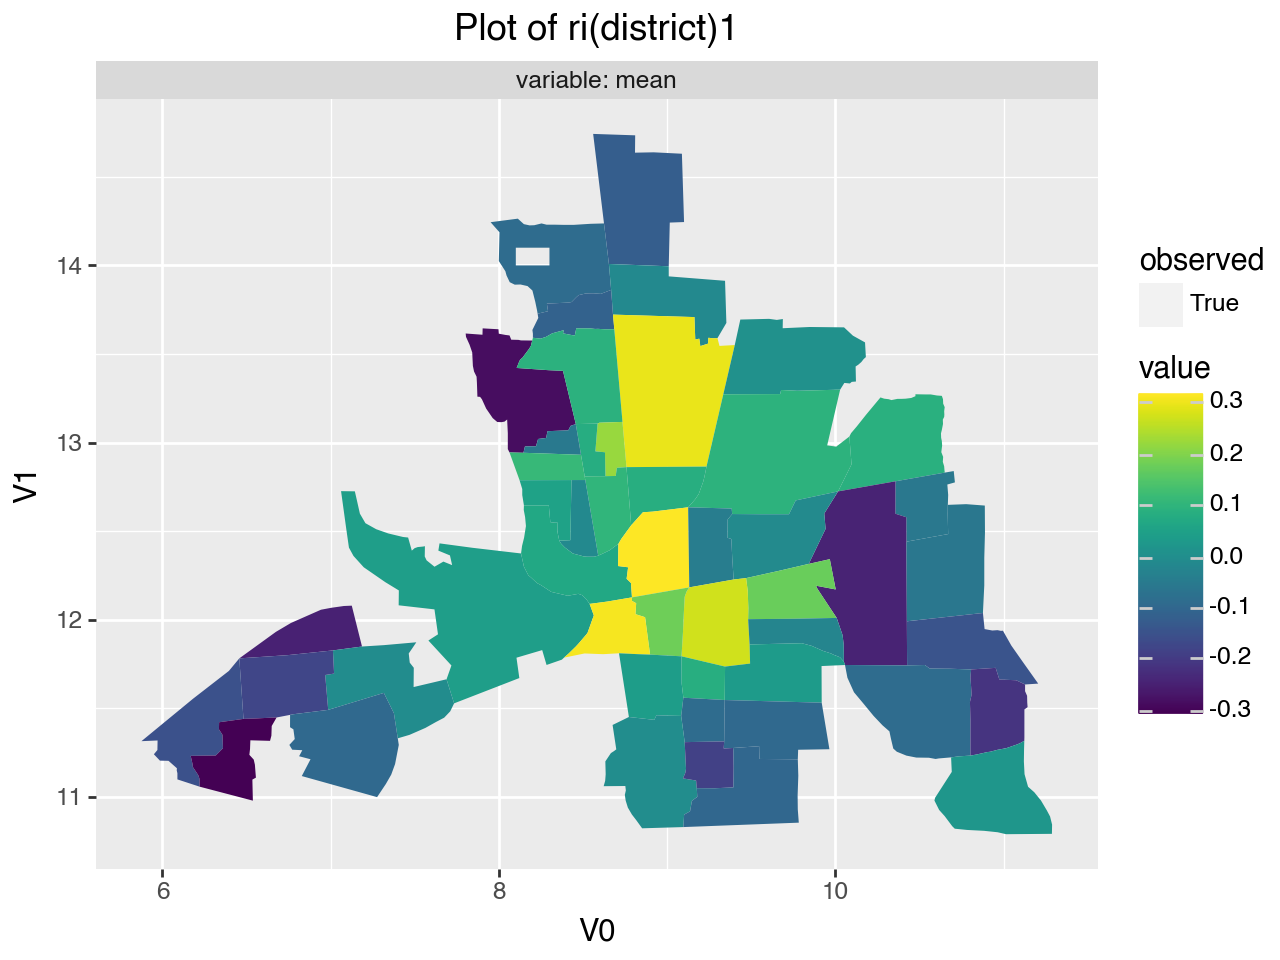

In [21]:
gam.plot_regions(term=model.vars["ri(district)1"], samples=samples, polys=polys)